In [1]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 9.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
import string

import csv
import requests
from io import StringIO

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import joblib

In [ ]:
# import data
data = pd.read_csv('ulasan_aplikasi_pertamina.csv')
data

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,bfc59f6b-138f-48d5-8e6d-6ea89a686ae7,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,kebanyakan upgrade terus,1,0,4.6.6,2025-04-11 10:28:30,"Hai, Sobat Supriadi. Mohon maaf atas ketidakny...",2025-04-11 14:24:00,4.6.6
1,04748ba4-d9ea-4894-a5aa-5029cf5b6a5f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,gini ya aplikasi kalo di biayai negara,1,0,4.6.9,2025-04-11 10:16:45,NaN,NaN,4.6.9
2,b50b2111-e996-4157-b57e-08d350b13c43,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,perbaiki lagi dong aplikasi nya jangan eror te...,1,0,4.6.9,2025-04-11 09:38:11,"Hai, Sobat. Mohon maaf atas ketidaknyamanan ya...",2025-04-11 14:25:25,4.6.9
3,d88492d6-8ad2-433e-be70-83112483c0cd,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,apk rusak tdak berguna,1,0,4.6.9,2025-04-11 09:10:48,NaN,NaN,4.6.9
4,74e75193-f7f8-4a99-be66-bb38bb2626ed,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,katanya harus serba online serba aplikasi . ta...,1,0,4.6.9,2025-04-11 09:10:02,"Hai, Sobat Pipit. Mimin sampaikan selain mengg...",2025-04-11 13:55:12,4.6.9
...,...,...,...,...,...,...,...,...,...,...,...
14995,402a356a-10cc-4d69-9d50-ddbe8bbc34d6,Rokhadin,https://play-lh.googleusercontent.com/a-/ALV-U...,Mencoba menambahkan metode pembayaran OVO dan ...,4,1,4.3.3,2024-07-29 05:50:56,NaN,NaN,4.3.3
14996,a080f6eb-4528-4a79-a7a4-adc072bd699c,ahmad gozali,https://play-lh.googleusercontent.com/a-/ALV-U...,Luar biaasa membantu,5,0,4.3.1,2024-07-29 05:16:43,NaN,NaN,4.3.1
14997,7bd7f5d2-52b7-445b-958b-7a93a5c2d3cf,Apo Ricky,https://play-lh.googleusercontent.com/a/ACg8oc...,bagus,4,0,4.3.3,2024-07-29 02:03:12,NaN,NaN,4.3.3
14998,56d65eb1-102a-463a-aa4d-913ab1787109,Baiq Erika,https://play-lh.googleusercontent.com/a-/ALV-U...,Di event MXGP Lombok ahir juni 2024 disuruh in...,1,4,4.3.3,2024-07-29 00:08:26,NaN,NaN,4.3.3


Dari data di atas, analisis hanya akan difokuskan pada variabel yaitu variabel content dan variabel score. Variabel content akan digunakan sebagai fitur sedangkan variabel score akan digumakan untuk pembentukan label target.

In [5]:
content_data = data[['content']].copy()
content_data

,content
0,kebanyakan upgrade terus
1,gini ya aplikasi kalo di biayai negara
2,perbaiki lagi dong aplikasi nya jangan eror te...
3,apk rusak tdak berguna
4,katanya harus serba online serba aplikasi . ta...
...,...
14995,Mencoba menambahkan metode pembayaran OVO dan ...
14996,Luar biaasa membantu
14997,bagus
14998,Di event MXGP Lombok ahir juni 2024 disuruh in...


# Preprocessing

Langkah preprocessing dilakukan untuk membersihkan data teks agar lebih siap digunakan untuk analisis lebih lanjut.

In [7]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', ' ', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', ' ', text) # menghapus RT
    text = re.sub(r"http\S+", ' ', text) # menghapus link
    text = re.sub(r'[0-9]+', ' ', text) # menghapus angka
    text = re.sub(r'[^\w\s]', ' ', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = re.sub(r'\s+', ' ', text) # Menghapus whitespace (spasi ganda, tab, newline)
    text = text.strip()
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    # List 1
    listStopwords = set(stopwords.words('indonesian'))

    # List 2
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)

    # List 3
    factory = StopWordRemoverFactory()
    listStopwords2 = factory.get_stop_words()
    listStopwords.update(listStopwords2)

    # Additional
    listStopwords.update([
    'iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di', 'ga', 'ya', 'gaa',
    'loh', 'kah', 'woi', 'woii', 'woy', 'kalau', 'terus', 'kan', 'hahaha',
    'jadi', 'kayak', 'kok', 'lah', 'entah', 'mah', 'eh', 'deh'
    ])

    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(words): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    return stemmed_words

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [8]:
# Slang Words
# kamus 1
sl1 = {"@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin", "apk": "aplikasi", "apl": "aplikasi", "tf": "transfer", "trx": "transaksi"}

# kamus 3
sl3 = pd.read_csv("https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt", sep="\t", header=None)
sl3.set_index(0, drop=True, inplace=True)
sl3 = sl3.to_dict()[1]

# Gabungkan semua kamus slang words
slangwords = {**sl1, **sl3}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

Langkah pertama pada preprocessing adalah melakukan cleaning text yang bertujuan menghapus elemen-elemen tidak berguna dari data text.

In [9]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
content_data['text_clean'] = content_data['content'].apply(cleaningText)
content_data

,content,text_clean
0,kebanyakan upgrade terus,kebanyakan upgrade terus
1,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara
2,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...
3,apk rusak tdak berguna,apk rusak tdak berguna
4,katanya harus serba online serba aplikasi . ta...,katanya harus serba online serba aplikasi tapi...
...,...,...
14995,Mencoba menambahkan metode pembayaran OVO dan ...,Mencoba menambahkan metode pembayaran OVO dan ...
14996,Luar biaasa membantu,Luar biaasa membantu
14997,bagus,bagus
14998,Di event MXGP Lombok ahir juni 2024 disuruh in...,Di event MXGP Lombok ahir juni disuruh instal ...


Selanjutnya, dilakukan case folding untuk menyeragamkan bentuk teks.

In [10]:
# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
content_data['text_casefoldingText'] = content_data['text_clean'].apply(casefoldingText)
content_data

,content,text_clean,text_casefoldingText
0,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus
1,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara
2,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...
3,apk rusak tdak berguna,apk rusak tdak berguna,apk rusak tdak berguna
4,katanya harus serba online serba aplikasi . ta...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...
...,...,...,...
14995,Mencoba menambahkan metode pembayaran OVO dan ...,Mencoba menambahkan metode pembayaran OVO dan ...,mencoba menambahkan metode pembayaran ovo dan ...
14996,Luar biaasa membantu,Luar biaasa membantu,luar biaasa membantu
14997,bagus,bagus,bagus
14998,Di event MXGP Lombok ahir juni 2024 disuruh in...,Di event MXGP Lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...


Selanjutnya, pada data text terdapat slang words yang akan diubah menjadi kata-kata standar sesuai dengan kamus yang telah dberikan.

In [11]:
# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
content_data['text_slangwords'] = content_data['text_casefoldingText'].apply(fix_slangwords)
content_data

,content,text_clean,text_casefoldingText,text_slangwords
0,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus
1,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,begini iya aplikasi kalau di biayai negara
2,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...
3,apk rusak tdak berguna,apk rusak tdak berguna,apk rusak tdak berguna,aplikasi rusak tdak berguna
4,katanya harus serba online serba aplikasi . ta...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...
...,...,...,...,...
14995,Mencoba menambahkan metode pembayaran OVO dan ...,Mencoba menambahkan metode pembayaran OVO dan ...,mencoba menambahkan metode pembayaran ovo dan ...,mencoba menambahkan metode pembayaran ovo dan ...
14996,Luar biaasa membantu,Luar biaasa membantu,luar biaasa membantu,luar biaasa membantu
14997,bagus,bagus,bagus,bagus
14998,Di event MXGP Lombok ahir juni 2024 disuruh in...,Di event MXGP Lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...


Selanjutnya, dilakukan tokenisasi untuk memecah teks menjadi token (kata-kata).

In [12]:
# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
content_data['text_tokenizingText'] = content_data['text_slangwords'].apply(tokenizingText)
content_data

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText
0,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus,"[kebanyakan, upgrade, terus]"
1,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,begini iya aplikasi kalau di biayai negara,"[begini, iya, aplikasi, kalau, di, biayai, neg..."
2,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,"[perbaiki, lagi, dong, aplikasi, nya, jangan, ..."
3,apk rusak tdak berguna,apk rusak tdak berguna,apk rusak tdak berguna,aplikasi rusak tdak berguna,"[aplikasi, rusak, tdak, berguna]"
4,katanya harus serba online serba aplikasi . ta...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...,"[katanya, harus, serba, online, serba, aplikas..."
...,...,...,...,...,...
14995,Mencoba menambahkan metode pembayaran OVO dan ...,Mencoba menambahkan metode pembayaran OVO dan ...,mencoba menambahkan metode pembayaran ovo dan ...,mencoba menambahkan metode pembayaran ovo dan ...,"[mencoba, menambahkan, metode, pembayaran, ovo..."
14996,Luar biaasa membantu,Luar biaasa membantu,luar biaasa membantu,luar biaasa membantu,"[luar, biaasa, membantu]"
14997,bagus,bagus,bagus,bagus,[bagus]
14998,Di event MXGP Lombok ahir juni 2024 disuruh in...,Di event MXGP Lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...,"[di, event, mxgp, lombok, ahir, juni, disuruh,..."


Selanjutnya, dilakukan penghapusan stop wrods atau kata-kata umum dari data agar analisis nantinya lebih berfokus pada kata-kata yang memilili makna penting.

In [13]:
# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
content_data['text_stopword'] = content_data['text_tokenizingText'].apply(filteringText)
content_data

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword
0,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus,"[kebanyakan, upgrade, terus]","[kebanyakan, upgrade]"
1,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,begini iya aplikasi kalau di biayai negara,"[begini, iya, aplikasi, kalau, di, biayai, neg...","[aplikasi, biayai, negara]"
2,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,"[perbaiki, lagi, dong, aplikasi, nya, jangan, ...","[perbaiki, aplikasi, eror, kasih, peraturan, p..."
3,apk rusak tdak berguna,apk rusak tdak berguna,apk rusak tdak berguna,aplikasi rusak tdak berguna,"[aplikasi, rusak, tdak, berguna]","[aplikasi, rusak, tdak, berguna]"
4,katanya harus serba online serba aplikasi . ta...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...,"[katanya, harus, serba, online, serba, aplikas...","[serba, online, serba, aplikasi, sungguh, meny..."
...,...,...,...,...,...,...
14995,Mencoba menambahkan metode pembayaran OVO dan ...,Mencoba menambahkan metode pembayaran OVO dan ...,mencoba menambahkan metode pembayaran ovo dan ...,mencoba menambahkan metode pembayaran ovo dan ...,"[mencoba, menambahkan, metode, pembayaran, ovo...","[mencoba, metode, pembayaran, ovo, go, pay, ga..."
14996,Luar biaasa membantu,Luar biaasa membantu,luar biaasa membantu,luar biaasa membantu,"[luar, biaasa, membantu]","[biaasa, membantu]"
14997,bagus,bagus,bagus,bagus,[bagus],[bagus]
14998,Di event MXGP Lombok ahir juni 2024 disuruh in...,Di event MXGP Lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...,"[di, event, mxgp, lombok, ahir, juni, disuruh,...","[event, mxgp, lombok, ahir, juni, disuruh, ins..."


Selanjutnya, dilakukan stemming untuk mengubah kata-kata ke bentuk dasarnya.

In [14]:
# Stemming
content_data['text_stemming'] = content_data['text_stopword'].apply(stemmingText)
content_data

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming
0,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus,"[kebanyakan, upgrade, terus]","[kebanyakan, upgrade]","[banyak, upgrade]"
1,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,begini iya aplikasi kalau di biayai negara,"[begini, iya, aplikasi, kalau, di, biayai, neg...","[aplikasi, biayai, negara]","[aplikasi, biaya, negara]"
2,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,"[perbaiki, lagi, dong, aplikasi, nya, jangan, ...","[perbaiki, aplikasi, eror, kasih, peraturan, p...","[baik, aplikasi, eror, kasih, atur, atur, apli..."
3,apk rusak tdak berguna,apk rusak tdak berguna,apk rusak tdak berguna,aplikasi rusak tdak berguna,"[aplikasi, rusak, tdak, berguna]","[aplikasi, rusak, tdak, berguna]","[aplikasi, rusak, tdak, guna]"
4,katanya harus serba online serba aplikasi . ta...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...,"[katanya, harus, serba, online, serba, aplikas...","[serba, online, serba, aplikasi, sungguh, meny...","[serba, online, serba, aplikasi, sungguh, susa..."
...,...,...,...,...,...,...,...
14995,Mencoba menambahkan metode pembayaran OVO dan ...,Mencoba menambahkan metode pembayaran OVO dan ...,mencoba menambahkan metode pembayaran ovo dan ...,mencoba menambahkan metode pembayaran ovo dan ...,"[mencoba, menambahkan, metode, pembayaran, ovo...","[mencoba, metode, pembayaran, ovo, go, pay, ga...","[coba, metode, bayar, ovo, go, pay, gagal, salah]"
14996,Luar biaasa membantu,Luar biaasa membantu,luar biaasa membantu,luar biaasa membantu,"[luar, biaasa, membantu]","[biaasa, membantu]","[biaasa, bantu]"
14997,bagus,bagus,bagus,bagus,[bagus],[bagus],[bagus]
14998,Di event MXGP Lombok ahir juni 2024 disuruh in...,Di event MXGP Lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...,"[di, event, mxgp, lombok, ahir, juni, disuruh,...","[event, mxgp, lombok, ahir, juni, disuruh, ins...","[event, mxgp, lombok, ahir, juni, suruh, insta..."


Pada tahap akhir prepo, hasil token-token yang telah melewati beberapa tahap hingga stemming digabung kembali menjadi suatu kalimat.

In [15]:
# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
content_data['text_akhir'] = content_data['text_stemming'].apply(toSentence)
content_data

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming,text_akhir
0,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus,"[kebanyakan, upgrade, terus]","[kebanyakan, upgrade]","[banyak, upgrade]",banyak upgrade
1,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,begini iya aplikasi kalau di biayai negara,"[begini, iya, aplikasi, kalau, di, biayai, neg...","[aplikasi, biayai, negara]","[aplikasi, biaya, negara]",aplikasi biaya negara
2,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,"[perbaiki, lagi, dong, aplikasi, nya, jangan, ...","[perbaiki, aplikasi, eror, kasih, peraturan, p...","[baik, aplikasi, eror, kasih, atur, atur, apli...",baik aplikasi eror kasih atur atur aplikasi op...
3,apk rusak tdak berguna,apk rusak tdak berguna,apk rusak tdak berguna,aplikasi rusak tdak berguna,"[aplikasi, rusak, tdak, berguna]","[aplikasi, rusak, tdak, berguna]","[aplikasi, rusak, tdak, guna]",aplikasi rusak tdak guna
4,katanya harus serba online serba aplikasi . ta...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...,"[katanya, harus, serba, online, serba, aplikas...","[serba, online, serba, aplikasi, sungguh, meny...","[serba, online, serba, aplikasi, sungguh, susa...",serba online serba aplikasi sungguh susah klai...
...,...,...,...,...,...,...,...,...
14995,Mencoba menambahkan metode pembayaran OVO dan ...,Mencoba menambahkan metode pembayaran OVO dan ...,mencoba menambahkan metode pembayaran ovo dan ...,mencoba menambahkan metode pembayaran ovo dan ...,"[mencoba, menambahkan, metode, pembayaran, ovo...","[mencoba, metode, pembayaran, ovo, go, pay, ga...","[coba, metode, bayar, ovo, go, pay, gagal, salah]",coba metode bayar ovo go pay gagal salah
14996,Luar biaasa membantu,Luar biaasa membantu,luar biaasa membantu,luar biaasa membantu,"[luar, biaasa, membantu]","[biaasa, membantu]","[biaasa, bantu]",biaasa bantu
14997,bagus,bagus,bagus,bagus,[bagus],[bagus],[bagus],bagus
14998,Di event MXGP Lombok ahir juni 2024 disuruh in...,Di event MXGP Lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...,"[di, event, mxgp, lombok, ahir, juni, disuruh,...","[event, mxgp, lombok, ahir, juni, disuruh, ins...","[event, mxgp, lombok, ahir, juni, suruh, insta...",event mxgp lombok ahir juni suruh instal aplik...


Dari data tersebut, diperoleh terdapat beberapa baris data yang menghasilkan output kosong setelah dilakukan tahapan preprocessing, sehingga akan dilakukan penanganan dengan menghapus baris yang missing.

In [16]:
content_data.replace("", np.nan, inplace=True)
content_data.isna().sum()

content                   0
text_clean               74
text_casefoldingText     74
text_slangwords          74
text_tokenizingText       0
text_stopword             0
text_stemming             0
text_akhir              954
dtype: int64

In [17]:
content_data.dropna(inplace=True)
content_data

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming,text_akhir
0,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus,"[kebanyakan, upgrade, terus]","[kebanyakan, upgrade]","[banyak, upgrade]",banyak upgrade
1,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,begini iya aplikasi kalau di biayai negara,"[begini, iya, aplikasi, kalau, di, biayai, neg...","[aplikasi, biayai, negara]","[aplikasi, biaya, negara]",aplikasi biaya negara
2,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,"[perbaiki, lagi, dong, aplikasi, nya, jangan, ...","[perbaiki, aplikasi, eror, kasih, peraturan, p...","[baik, aplikasi, eror, kasih, atur, atur, apli...",baik aplikasi eror kasih atur atur aplikasi op...
3,apk rusak tdak berguna,apk rusak tdak berguna,apk rusak tdak berguna,aplikasi rusak tdak berguna,"[aplikasi, rusak, tdak, berguna]","[aplikasi, rusak, tdak, berguna]","[aplikasi, rusak, tdak, guna]",aplikasi rusak tdak guna
4,katanya harus serba online serba aplikasi . ta...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...,"[katanya, harus, serba, online, serba, aplikas...","[serba, online, serba, aplikasi, sungguh, meny...","[serba, online, serba, aplikasi, sungguh, susa...",serba online serba aplikasi sungguh susah klai...
...,...,...,...,...,...,...,...,...
14995,Mencoba menambahkan metode pembayaran OVO dan ...,Mencoba menambahkan metode pembayaran OVO dan ...,mencoba menambahkan metode pembayaran ovo dan ...,mencoba menambahkan metode pembayaran ovo dan ...,"[mencoba, menambahkan, metode, pembayaran, ovo...","[mencoba, metode, pembayaran, ovo, go, pay, ga...","[coba, metode, bayar, ovo, go, pay, gagal, salah]",coba metode bayar ovo go pay gagal salah
14996,Luar biaasa membantu,Luar biaasa membantu,luar biaasa membantu,luar biaasa membantu,"[luar, biaasa, membantu]","[biaasa, membantu]","[biaasa, bantu]",biaasa bantu
14997,bagus,bagus,bagus,bagus,[bagus],[bagus],[bagus],bagus
14998,Di event MXGP Lombok ahir juni 2024 disuruh in...,Di event MXGP Lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...,"[di, event, mxgp, lombok, ahir, juni, disuruh,...","[event, mxgp, lombok, ahir, juni, disuruh, ins...","[event, mxgp, lombok, ahir, juni, suruh, insta...",event mxgp lombok ahir juni suruh instal aplik...


Dari 15000 data awal, tersisa sebanyak 14046 baris data yang akan dgunakan untuk analisis dengan sebaran data untuk setiap target sebagai berikut.

# Labelling

In [18]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")
 
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()
 
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
 
if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
 
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [39]:
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
 
    score = 0
    # Inisialisasi skor sentimen ke 0
 
    for word in text:
        # Mengulangi setiap kata dalam teks
 
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen
 
    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)
 
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen
 
    polarity=''
    # Inisialisasi variabel polaritas
 
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
         polarity = 'neutral'
 
    return score, polarity

Dalam melakukan labelling data, digunakan pendekatan berbasis leksikon (lexicon-based) dimana setiap teks akan diuraikan menjadi kata-kata, lalu dibandingkan dengan kamus sentimen berbahasa Indonesia yang terdiri dari dua bagian: lexicon_positive untuk kata-kata positif, dan lexicon_negative untuk kata-kata negatif. Setiap kata yang ditemukan dalam kamus akan diberikan skor tertentu kemudian dijumlahkan untuk membentuk total skor sentimen dari teks tersebut. Jika total skor lebih besar dari nol, teks akan diberi label positive. Jika total skor kurang dari nol, teks diberi label negative. Namun, jika total skor sama dengan nol, maka teks dianggap memiliki sentimen netral dan diberi label neutral. Penentuan label netral pada total skor sama dengan nol dikarenakan skor 0 bisa jadi didapatkan karena tidak ada kata yang cocok pada kamus positif maupun negatif atau skor positif dan negatif saling meniadakan sehingga opini yang memiliki total skor ini dapat dikatakan memiliki opini yang tidak condong kemana-mana.

Berikut adalah sebaran dari label data setelah dilakukan labelling.

In [40]:
results = content_data['text_stemming'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
content_data['polarity_score'] = results[0]
content_data['polarity'] = results[1]
print(content_data['polarity'].value_counts())

polarity
negative    9177
positive    3052
neutral     1817
Name: count, dtype: int64


In [41]:
content_data

,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_stemming,text_akhir,polarity_score,polarity
0,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus,kebanyakan upgrade terus,"[kebanyakan, upgrade, terus]","[kebanyakan, upgrade]","[banyak, upgrade]",banyak upgrade,0,neutral
1,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,gini ya aplikasi kalo di biayai negara,begini iya aplikasi kalau di biayai negara,"[begini, iya, aplikasi, kalau, di, biayai, neg...","[aplikasi, biayai, negara]","[aplikasi, biaya, negara]",aplikasi biaya negara,-4,negative
2,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,perbaiki lagi dong aplikasi nya jangan eror te...,"[perbaiki, lagi, dong, aplikasi, nya, jangan, ...","[perbaiki, aplikasi, eror, kasih, peraturan, p...","[baik, aplikasi, eror, kasih, atur, atur, apli...",baik aplikasi eror kasih atur atur aplikasi op...,-9,negative
3,apk rusak tdak berguna,apk rusak tdak berguna,apk rusak tdak berguna,aplikasi rusak tdak berguna,"[aplikasi, rusak, tdak, berguna]","[aplikasi, rusak, tdak, berguna]","[aplikasi, rusak, tdak, guna]",aplikasi rusak tdak guna,-4,negative
4,katanya harus serba online serba aplikasi . ta...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...,katanya harus serba online serba aplikasi tapi...,"[katanya, harus, serba, online, serba, aplikas...","[serba, online, serba, aplikasi, sungguh, meny...","[serba, online, serba, aplikasi, sungguh, susa...",serba online serba aplikasi sungguh susah klai...,-5,negative
...,...,...,...,...,...,...,...,...,...,...
14995,Mencoba menambahkan metode pembayaran OVO dan ...,Mencoba menambahkan metode pembayaran OVO dan ...,mencoba menambahkan metode pembayaran ovo dan ...,mencoba menambahkan metode pembayaran ovo dan ...,"[mencoba, menambahkan, metode, pembayaran, ovo...","[mencoba, metode, pembayaran, ovo, go, pay, ga...","[coba, metode, bayar, ovo, go, pay, gagal, salah]",coba metode bayar ovo go pay gagal salah,-14,negative
14996,Luar biaasa membantu,Luar biaasa membantu,luar biaasa membantu,luar biaasa membantu,"[luar, biaasa, membantu]","[biaasa, membantu]","[biaasa, bantu]",biaasa bantu,-1,negative
14997,bagus,bagus,bagus,bagus,[bagus],[bagus],[bagus],bagus,-2,negative
14998,Di event MXGP Lombok ahir juni 2024 disuruh in...,Di event MXGP Lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...,di event mxgp lombok ahir juni disuruh instal ...,"[di, event, mxgp, lombok, ahir, juni, disuruh,...","[event, mxgp, lombok, ahir, juni, disuruh, ins...","[event, mxgp, lombok, ahir, juni, suruh, insta...",event mxgp lombok ahir juni suruh instal aplik...,-18,negative


Selanjutnya, akan dilihat sebaran kata yang terdapat pada data.

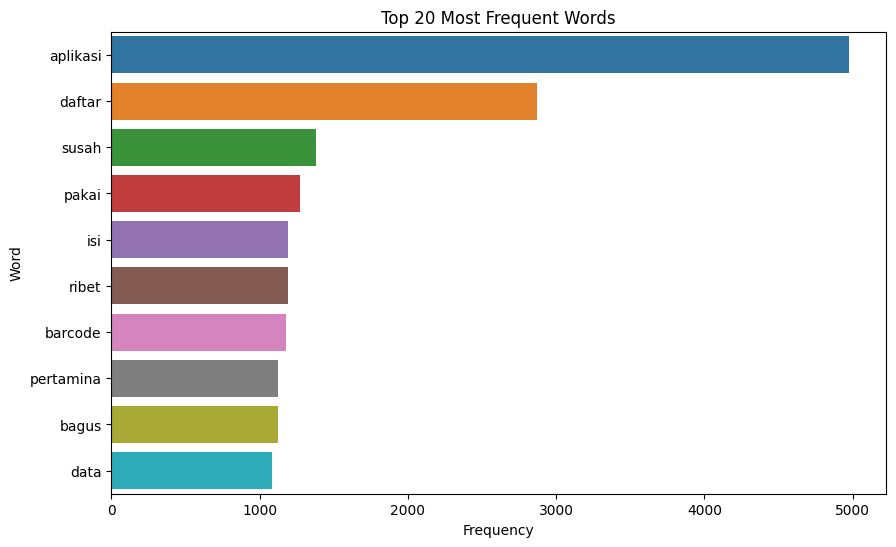

In [42]:
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(content_data['text_akhir'])

# Sum the word counts for each word
word_counts = X.toarray().sum(axis=0)

# Get the words and their corresponding counts
words = vectorizer.get_feature_names_out()
word_freq = pd.DataFrame({'word': words, 'count': word_counts})

# Sort the DataFrame by count in descending order
word_freq = word_freq.sort_values(by='count', ascending=False)

# Plot the top 10 words
top_n = 10
top_words = word_freq.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_words['count'], y=top_words['word'])
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

Grafik di atas menunjukkan 10 kata yang sering muncul pada ulasan aplikasi MyPertamina. Kata “aplikasi” muncul dengan frekuensi tertinggi, menunjukkan bahwa topik utama pembicaraan memang seputar aplikasi tersebut. Selanjutnya, kata “daftar” juga cukup sering disebut, yang mengindikasikan bahwa proses pendaftaran menjadi perhatian penting bagi pengguna. Kemunculan kata-kata seperti “susah” dan “ribet” memperkuat indikasi bahwa banyak pengguna mengalami kesulitan dalam penggunaan aplikasi, terutama saat mendaftar atau mengakses fitur-fitur tertentu. Kata “pakai” dan “isi” menggambarkan pengalaman penggunaan dan interaksi pengguna terhadap aplikasi, sementara “barcode” menyoroti fitur teknis yang sering dibahas dan digunakan oleh pengguna pada aplikasi tersebut. Meskipun terdapat kata bernada positif seperti “bagus”, secara umum kata-kata negatif tampak lebih dominan.

Selanjutnya, akan dibuat wordcloud untuk masing-masing label.

In [43]:
def plot_wordcloud_and_frequency(df, text_column, label_column, num_word = 10):
    labels = df[label_column].unique()
    num_cols = 2

    for label in labels:
        fig, axes = plt.subplots(1, num_cols, figsize=(12, 6))

        # Filter text by label
        text = " ".join(df[df[label_column] == label][text_column])

        # Generate wordcloud with a colormap
        wordcloud = WordCloud(width=400, height=400,
                              background_color='white',
                              min_font_size=10,
                              colormap='viridis').generate(text)

        # Display wordcloud
        axes[0].imshow(wordcloud)
        axes[0].axis("off")
        axes[0].set_title(f'WordCloud - {label}')

        # Compute word frequency
        text_data = df[df[label_column] == label][text_column]
        word_frequency = text_data.str.split(expand=True).stack().value_counts()
        freq = word_frequency.head(num_word) # adjust numbers of word

        # Display word frequency bar plot with a color palette
        sns.barplot(x=freq.values, y=freq.index, ax=axes[1], palette="muted")
        axes[1].set_title(f'Word Frequency - {label}')
        axes[1].set_xlabel('Count')
        for p in axes[1].patches:
            axes[1].annotate("{:.0f}".format(p.get_width()), (p.get_x() + p.get_width(), p.get_y() + .5), ha='left', va='center')

        plt.tight_layout()
        plt.show()

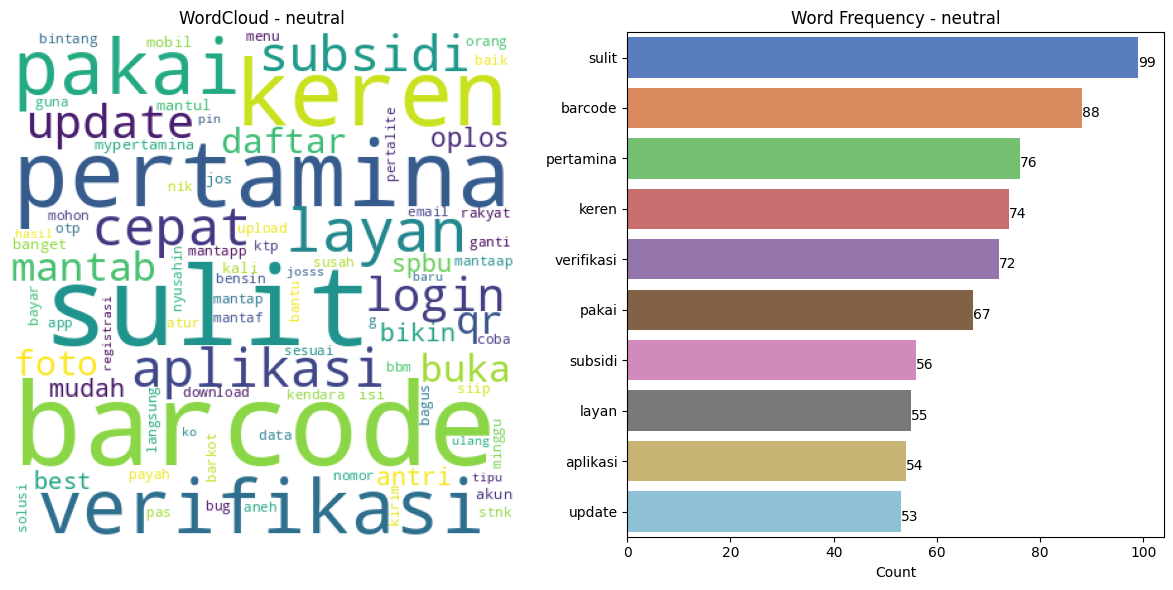

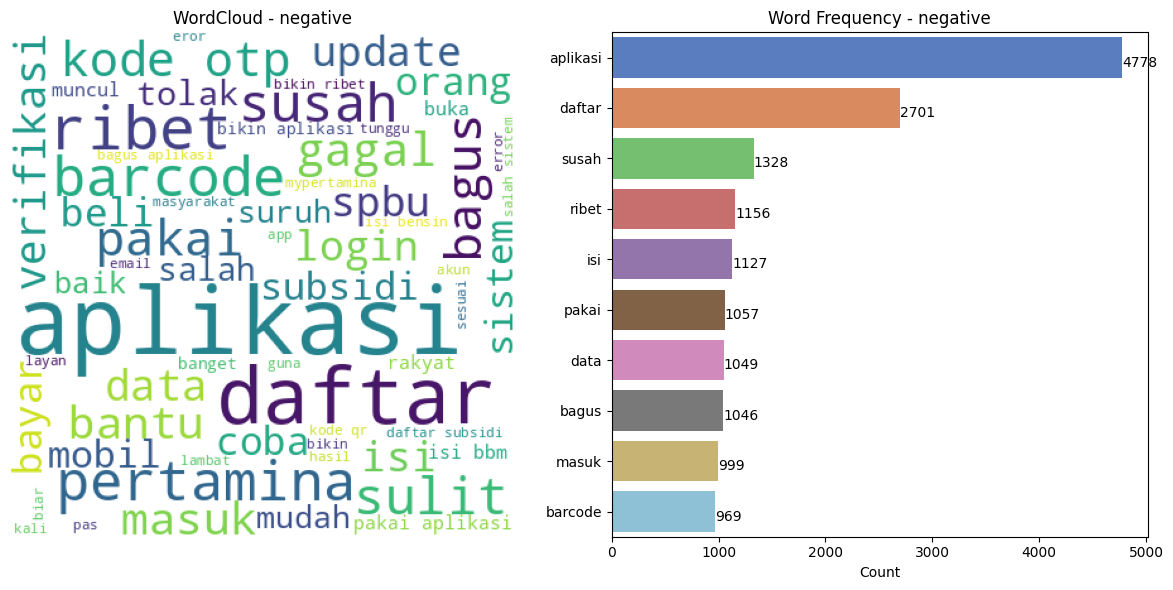

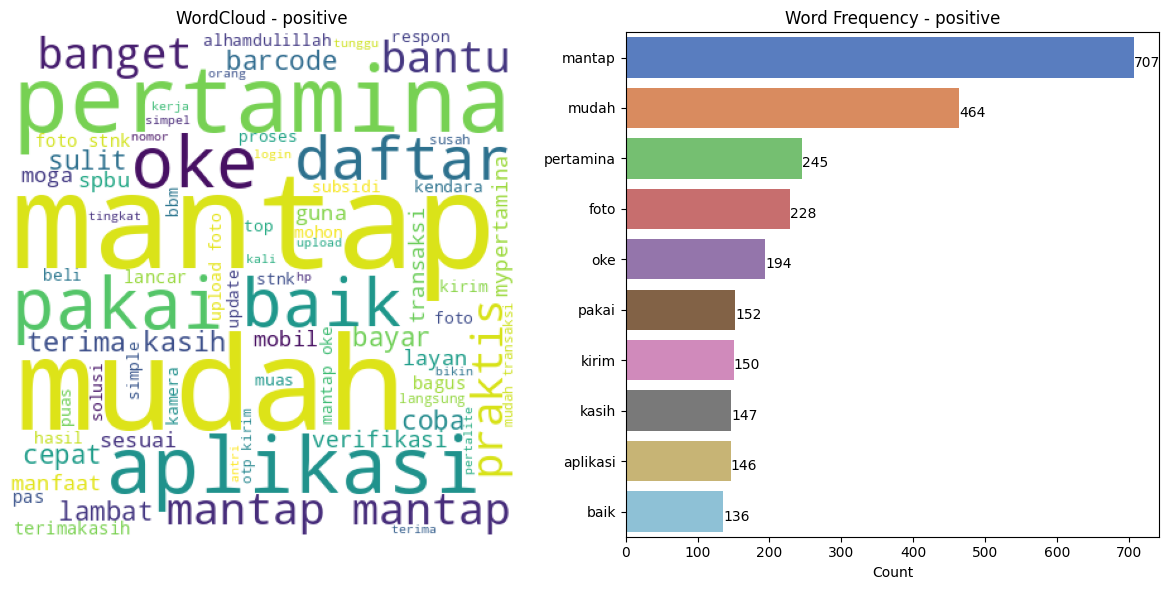

In [44]:
plot_wordcloud_and_frequency(content_data, 'text_akhir', 'polarity', 10)

Pada wordcloud sentimen netral, kata yang paling sering muncul adalah “sulit” (99 kali), diikuti oleh “barcode”, “pertamina”, “keren”, dan “verifikasi”. Kata “sulit” dalam konteks netral bisa mencerminkan komentar yang bersifat observasional yang menyatakan kondisi. Kata “barcode”, “verifikasi”, dan “aplikasi” menunjukkan bahwa pengguna banyak membahas fitur atau proses teknis dalam aplikasi.

Dari wordcloud kelas negatif, kata yang paling dominan adalah “aplikasi” (4.778 kali), diikuti oleh “daftar” (2.701 kali), “susah”, “ribet”, “isi”, dan “login”. Kata-kata ini mencerminkan banyaknya keluhan terkait kesulitan dalam proses pendaftaran, pengisian data, hingga masalah teknis lainnya. Selain itu, kata-kata seperti “gagal”, “kode”, “otp”, dan “verifikasi” mengindikasikan bahwa pengguna mengalami hambatan dalam proses otorisasi dan penggunaan fitur utama aplikasi.

Sementara itu, pada wordcloud kelas positif, kata yang paling sering muncul adalah “mantap” (707 kali), diikuti oleh “mudah”, “pertamina”, “foto”, dan “oke”. Kata-kata ini mencerminkan apresiasi dan kepuasan dari pengguna terhadap pengalaman penggunaan aplikasi. Kemunculan kata “praktis”, “cepat”, dan “lancar” menunjukkan bahwa sebagian besar pengguna merasa aplikasi ini mudah digunakan dan memiliki performa yang baik.

In [45]:
data_fix = content_data[['text_akhir', 'polarity']].copy()
data_fix

,text_akhir,polarity
0,banyak upgrade,neutral
1,aplikasi biaya negara,negative
2,baik aplikasi eror kasih atur atur aplikasi op...,negative
3,aplikasi rusak tdak guna,negative
4,serba online serba aplikasi sungguh susah klai...,negative
...,...,...
14995,coba metode bayar ovo go pay gagal salah,negative
14996,biaasa bantu,negative
14997,bagus,negative
14998,event mxgp lombok ahir juni suruh instal aplik...,negative


In [46]:
data_fix['label_encoding'] = data_fix['polarity'].apply(lambda x: 0 if x == 'negative' else (1 if x == 'neutral' else 2))
data_fix

,text_akhir,polarity,label_encoding
0,banyak upgrade,neutral,1
1,aplikasi biaya negara,negative,0
2,baik aplikasi eror kasih atur atur aplikasi op...,negative,0
3,aplikasi rusak tdak guna,negative,0
4,serba online serba aplikasi sungguh susah klai...,negative,0
...,...,...,...
14995,coba metode bayar ovo go pay gagal salah,negative,0
14996,biaasa bantu,negative,0
14997,bagus,negative,0
14998,event mxgp lombok ahir juni suruh instal aplik...,negative,0


# Modelling

## Skema 1

Pada skema 1, akan dilakukan pelatihan dengan ketentuan sebagai berikut.
- Pelatihan: XGBoost
- Ekstraksi fitur: CountVctorizer
- Pembagian data: 80/20

In [65]:
X = data_fix['text_akhir']
y = data_fix['label_encoding']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ekstraksi fitur dengan CountVectorizer
count_vectorizer = CountVectorizer(max_features=400, min_df=20, max_df=0.7)
X_train = count_vectorizer.fit_transform(X_train)
X_test = count_vectorizer.transform(X_test)

In [66]:
# Training model
xg_skema1 = XGBClassifier(random_state = 42)
xg_skema1.fit(X_train.toarray(), y_train)

# Prediksi dan akurasi pada data train
y_pred_train = xg_skema1.predict(X_train.toarray())
accuracy_train = accuracy_score(y_train, y_pred_train)

# Prediksi dan akurasi pada data test
y_pred_test = xg_skema1.predict(X_test.toarray())
accuracy_test = accuracy_score(y_test, y_pred_test)

# Cetak hasil
print(f"Model: {type(xg_skema1).__name__}")
print(f"Accuracy Train: {accuracy_train:.4f}")
print(f"Accuracy Test: {accuracy_test:.4f}")

Model: XGBClassifier
Accuracy Train: 0.9379
Accuracy Test: 0.9181


Dengan menggunakan skema 1, yaitu data dilatih menggunakan model XGBoost, menerapkan ekstraksi fitur menggunakan CountVectorizer, dan dengan pembagian data 80/20 diperoleh nilai akurasi untuk data train sebesar 93.79% dan untuk data test sebesar 91.81%.

## Skema 2

Pada skema 2, akan dilakukan pelatihan dengan ketentuan sebagai berikut.
- Pelatihan: Random Forest
- Ekstraksi fitur: TF-IDF
- Pembagian data: 80/20

In [67]:
X = data_fix['text_akhir']
y = data_fix['label_encoding']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ekstraksi fitur dengan TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=400, min_df=20, max_df=0.7)
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [68]:
# Training model
rf_skema2 = RandomForestClassifier(random_state = 42)
rf_skema2.fit(X_train.toarray(), y_train)

# Prediksi dan akurasi pada data train
y_pred_train = rf_skema2.predict(X_train.toarray())
accuracy_train = accuracy_score(y_train, y_pred_train)

# Prediksi dan akurasi pada data test
y_pred_test = rf_skema2.predict(X_test.toarray())
accuracy_test = accuracy_score(y_test, y_pred_test)

# Cetak hasil
print(f"Model: {type(rf_skema2).__name__}")
print(f"Accuracy Train: {accuracy_train:.4f}")
print(f"Accuracy Test: {accuracy_test:.4f}")

Model: RandomForestClassifier
Accuracy Train: 0.9813
Accuracy Test: 0.9139


Dengan menggunakan skema 2, yaitu data dilatih menggunakan model Random Forest, menerapkan ekstraksi fitur menggunakan TF-IDF, dan dengan pembagian data 80/20 diperoleh nilai akurasi untuk data train sebesar 98.13% dan untuk data test sebesar 91.39%.

## Skema 3

Pada skema 3, akan dilakukan pelatihan dengan ketentuan sebagai berikut.
- Pelatihan: Random Forest
- Ekstraksi fitur: Hashing Vectorizer
- Pembagian data: 80/20

In [69]:
X = data_fix['text_akhir']
y = data_fix['label_encoding']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ekstraksi fitur dengan TF-IDF
hash_vectorizer = HashingVectorizer(n_features=1000)
X_train = hash_vectorizer.fit_transform(X_train)
X_test = hash_vectorizer.transform(X_test)

In [70]:
# Training model
rf_skema3 = RandomForestClassifier(random_state = 42)
rf_skema3.fit(X_train, y_train)

# Prediksi dan akurasi pada data train
y_pred_train = rf_skema3.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)

# Prediksi dan akurasi pada data test
y_pred_test = rf_skema3.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

# Cetak hasil
print(f"Model: {type(rf_skema3).__name__}")
print(f"Accuracy Train: {accuracy_train:.4f}")
print(f"Accuracy Test: {accuracy_test:.4f}")

Model: RandomForestClassifier
Accuracy Train: 0.9977
Accuracy Test: 0.9060


Dengan menggunakan skema 3, yaitu data dilatih menggunakan model Random Forest, menerapkan ekstraksi fitur menggunakan Hashing Vectorizer, dan dengan pembagian data 80/20 diperoleh nilai akurasi untuk data train sebesar 99.77% dan untuk data test sebesar 90.60%.

## Skema 4

Pada skema 4, akan dilakukan pelatihan dengan ketentuan sebagai berikut.
- Pelatihan: Deep Learning with MLP
- Ekstraksi fitur: TF-IDF
- Pembagian data: 80/20

In [71]:
X = data_fix['text_akhir']
y = data_fix['label_encoding']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ekstraksi fitur dengan TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=400, min_df=20, max_df=0.7)
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [72]:
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

mlp_skema4 = Sequential()
mlp_skema4.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
mlp_skema4.add(Dropout(0.3))
mlp_skema4.add(Dense(64, activation='relu'))
mlp_skema4.add(Dropout(0.3))
mlp_skema4.add(Dense(3, activation='softmax'))  

mlp_skema4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Training model
mlp_skema4.fit(
    X_train, y_train_cat,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6913 - loss: 0.7053
Epoch 1: val_accuracy improved from -inf to 0.91495, saving model to best_model.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 123s 342ms/step - accuracy: 0.6916 - loss: 0.7048 - val_accuracy: 0.9149 - val_loss: 0.2572 - learning_rate: 0.0010
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9176 - loss: 0.2541
Epoch 2: val_accuracy improved from 0.91495 to 0.92989, saving model to best_model.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9176 - loss: 0.2541 - val_accuracy: 0.9299 - val_loss: 0.2294 - learning_rate: 0.0010
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9344 - loss: 0.2145
Epoch 3: val_accuracy improved from 0.92989 to 0.93452, saving model to best_model.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9344 - loss: 0.2144 - val_accuracy: 0.9345 - val_loss: 0.2227 - learning_rate: 0.0010
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step -

In [73]:
train_loss, train_accuracy = mlp_skema4.evaluate(X_train, y_train_cat)
test_loss, test_accuracy = mlp_skema4.evaluate(X_test, y_test_cat)

# Menampilkan hasil akurasi
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

352/352 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9509 - loss: 0.1676
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9378 - loss: 0.2263
Training Accuracy: 0.9517
Testing Accuracy: 0.9345


**Simpan Model dan Vectorizer**

In [77]:
# Menyimpan model dan vectorizer skema 1 untuk inference/testing
# Vectorizer
joblib.dump(count_vectorizer, 'count_vectorizer.pkl')

# Model
joblib.dump(xg_skema1, 'xg_skema1.pkl')

['xg_skema1.pkl']